In [1]:
import sys
sys.path.append('..')
import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
import torchvision
import random
import os
import cv2
from matplotlib import pyplot as plt
from detr import detr_dataset as ds
from common import image
from common.config import val_annotation_file, val_img_od_dict_file, val_img_dir, train_annotation_file, train_img_od_dict_file, train_img_dir, img_size
from detr.config import cid_to_name
from torchvision import transforms
from detr import detr_model, examine, anno, anchor, detr_model_base
import random
%matplotlib inline

In [2]:
dicts_val = anno.build_img_dict(val_annotation_file, val_img_od_dict_file, task='od')
dicts_train = anno.build_img_dict(train_annotation_file, train_img_od_dict_file, task='od')

In [3]:
device = torch.device("cpu")
n_query = 200
model = detr_model_base.DETR(d_cont=384, d_enc_coord_emb=64, d_head=64, n_enc_layer=20, n_dec_layer=8, n_query=n_query)
# model = detr_model2.DETR(d=448, d_img_coord_emb=64, d_anchor_coord_emb=32, n_head=7, d_indic=64, n_attn_layer=20,
#                          anchors=anchors, exam_diff=True)
model.to(device)
n_head = 8

In [4]:
saved_state = torch.load(f'/Users/zx/Documents/ml/restart/resources/od_base_1426.pt',  map_location=device)
model.load_state_dict(saved_state)

extractor = examine.FeatureExtractor(model, layers=[m[0] for m in model.named_modules()])

In [6]:
# torch.save(model.encoder.state_dict(), f'/Users/zx/Documents/ml/restart/resources/enc_od_base_896.pt')
# torch.save(model.decoder.state_dict(), f'/Users/zx/Documents/ml/restart/resources/dec_od_base_896.pt')

3


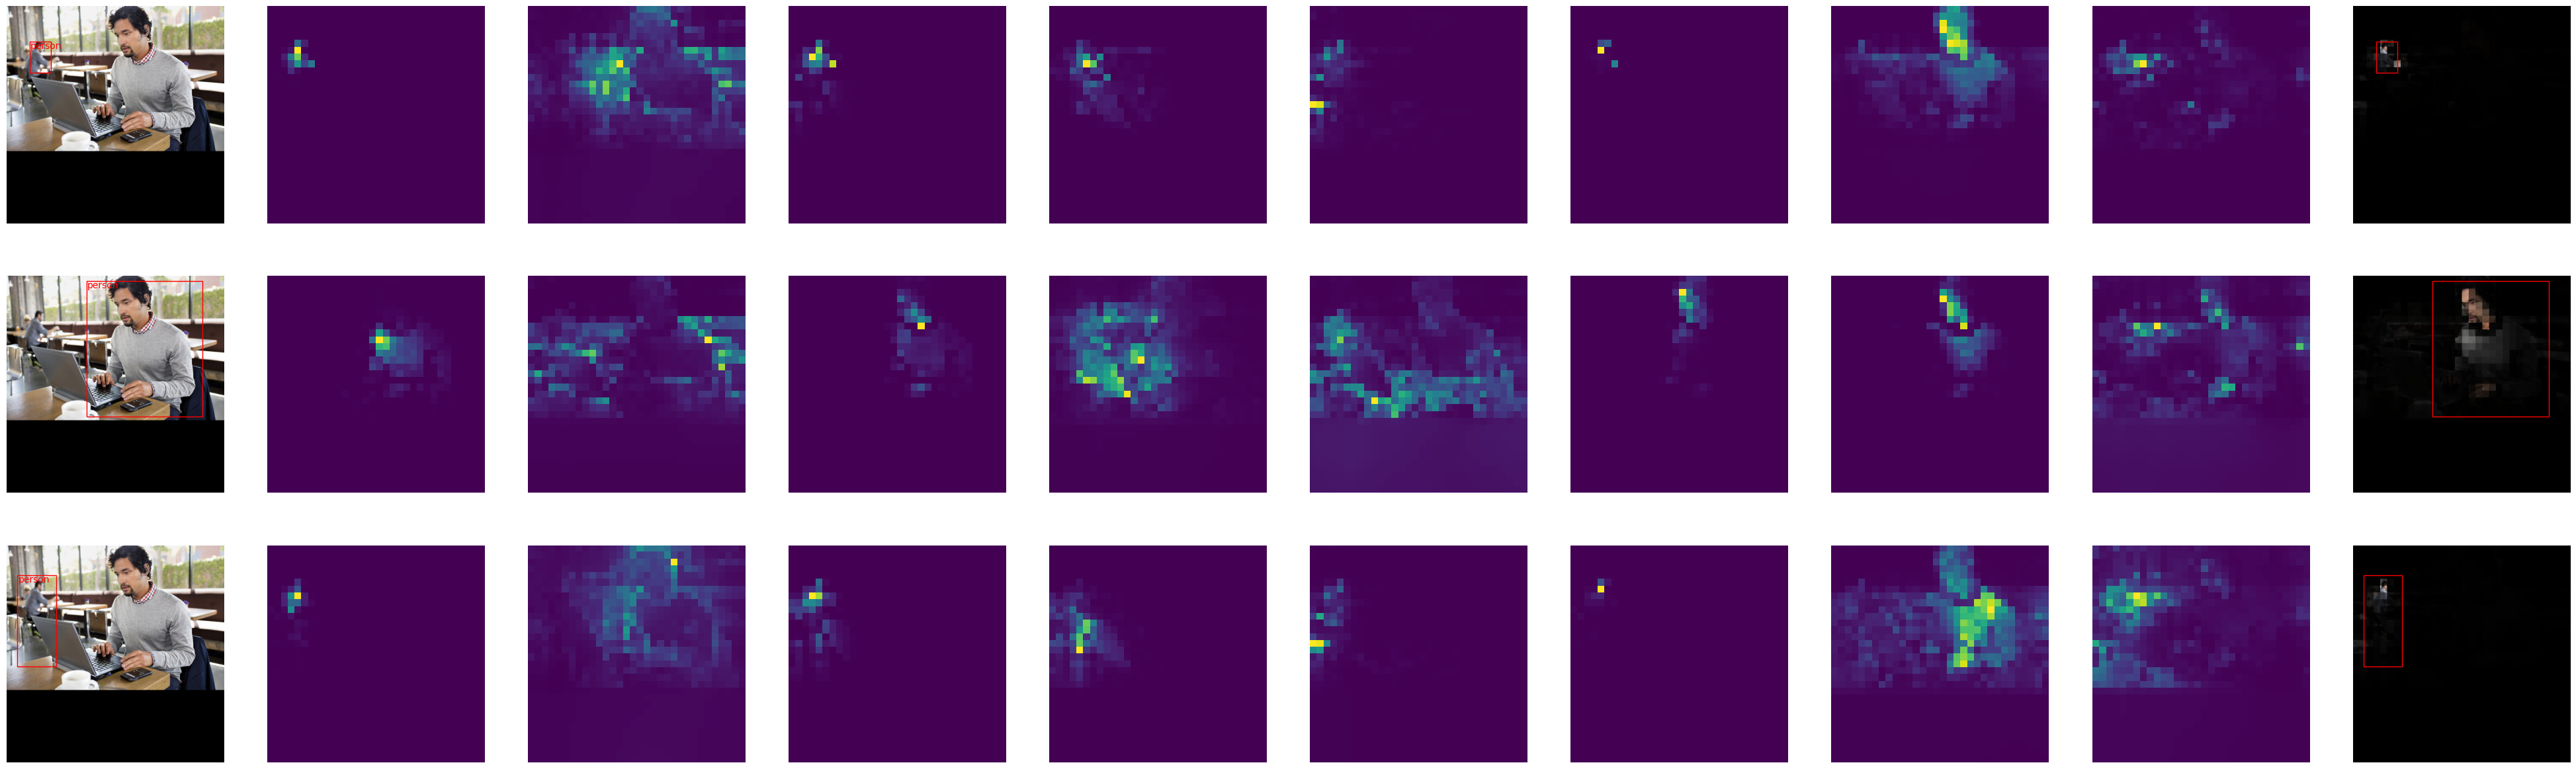

In [26]:
data = ds.OdDataset(dicts_val, n_query=n_query, train=False, sample_num=10, random_shift=False)
dl = DataLoader(data, batch_size=1, shuffle=True)

for img, boxes_gt_xyxy, cids, _, img_id in dl:
    img = img.to(device)
    img, anchors_, anchors_new, boxes, names, attns1, attns2, n_head, boxes_pred_xyxy, cls_pred = examine.examine_attn(
            img, extractor, n_head, device, 
            'decoder.dec_ca_layers.2.self_attn.q_proj', 'decoder.dec_ca_layers.2.self_attn.k_proj', 
            'decoder.dec_ca_layers.7.self_attn.q_proj', 'decoder.dec_ca_layers.7.self_attn.k_proj')
    print(len(boxes))
    examine.draw_attn(img, anchors_, anchors_new, boxes, names, attns1, n_head)
#     examine.draw_attn(img, anchors_, anchors_new, boxes, names, attns2, n_head)
    break


In [7]:
import cv2
import time
import numpy as np
 
def video_demo():
    capture = cv2.VideoCapture(0)#0为电脑内置摄像头
    fps = 0.0
    while(True):
        start_time = time.time()
        ret, frame = capture.read()#摄像头读取,ret为是否成功打开摄像头,true,false。 frame为视频的每一帧图像
        frame = cv2.flip(frame, 1)#摄像头是和人对立的，将图像左右调换回来正常显示。
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = torch.tensor(frame / 256)
        print(frame.shape)
        img, offset_h, offset_w = image.pad_img(frame, random_offset=False, content='zero', out_ratio=img_size[0] / img_size[1])
        resize_factor = img_size[0] / img.shape[0]
        img = torch.permute(img, [2, 0, 1])
        img = torchvision.transforms.Resize(img_size)(img)

        img_ = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
        img_ = torch.unsqueeze(img_, 0)
        img_ = img_.to(device)
        with torch.no_grad():
            boxes_pred_xyxy, cls_logits_pred, _, _ = model(img_)
        boxes_pred_xyxy = (boxes_pred_xyxy * max(img_size)).to(int)
        cls_pred = cls_logits_pred.argmax(-1)

        img = torch.permute(img, [1, 2, 0]).contiguous()
        img = img.cpu().numpy()
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        for i in range(n_query):
            cls = cls_pred[0][i].item()
            if cls == 0:
                continue
            name = cid_to_name.get(cls)
            x1, y1, x2, y2 = boxes_pred_xyxy[0, i]
            x1, y1, x2, y2 = x1.item(), y1.item(), x2.item(), y2.item()

            cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
            cv2.putText(img, name, (x1, y1 + 8), cv2.FONT_HERSHEY_SIMPLEX,  0.5,  (255,0,0), 2)
        
        end_time = time.time()
        fps = ( fps + (1. / (end_time - start_time)) ) / 2
        cv2.putText(img, f"fps={fps:.2f}", (0, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.imshow("video", img)
        c = cv2.waitKey(50)
        if c == 27:
            cv2.destroyAllWindows()
            break


In [8]:
video_demo()

torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
torch.Size([720, 1280, 3])
